# Initial exploration of the methylation data
----

Now I am only using the normal-H data. 

## <span class="label label-success"> Analysis </span>
- Histogram of beta in each sample
- Histogram of beta aggregated for samples
- Histogram of std  of beta among samples

---

## <span class="label label-warning">NOTE</span>
- Some outplier samples
- Double tail at 'No methylation'

---



## <span class="label label-info">Conclusions</span>
#### I will define to categories:
- Methylated: avg > 0.8
- Not methylated: avg < 0.2


#### STD should not be more than 0.1


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import subprocess
import time

import re

In [2]:
workdir='/nagyvinyok/adat84/sotejedlik/ribli/methylation_code/explore_data'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)
os.environ['TMPDIR']='/nagyvinyok/adat84/sotejedlik/ribli/tmp'

In [3]:
#sql exetcuter func
def run_sqlilte3(command,db,output=''):
    start=time.time()
    with open('tempf.sql','w') as tempf:
        tempf.write(command)
        
    if output != '':
        output=' > '+output
    
    try:
        print subprocess.check_output('/usr/bin/sqlite3 '+ db + ' < tempf.sql '+ output,
                                      shell=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError, e:
        print e.output
    
    subprocess.call(['rm','tempf.sql'])
    print 'It took',int(time.time()-start),'s'

### Create only normal-H table

In [4]:
run_sqlilte3('''
.separator "\t"

CREATE TABLE normal_H_meth AS 
SELECT m.sample,m.probe,m.beta
FROM meth as m
INNER JOIN disease_annot AS d ON m.sample=d.sample AND d.disease='normal-H';

--index to fetch results fast from one sample
CREATE INDEX nh_sample_probe_idx ON normal_H_meth(sample,probe,beta);

--index to fetch result fast from a probe 
CREATE INDEX nh_probe_sample_idx ON normal_H_meth(probe,sample,beta);

''',db='../db/meth_db')


It took 12 s


In [6]:
#Create index for the database

run_sqlilte3("""
.separator "\t"

--index to fetch results fast from one sample
CREATE INDEX nh_sample_probe_idx ON normal_H_meth(sample,probe,beta);

--index to fetch result fast from a probe 
CREATE INDEX nh_probe_sample_idx ON normal_H_meth(probe,sample,beta);

""",db='../db/meth_db')


It took 77 s



---
## Histogram of beta for each sample

In [7]:
run_sqlilte3('''
.separator "\t"

SELECT sample,ROUND(beta*1000)*0.001 AS fbin,COUNT(*) AS c
FROM normal_h_meth
GROUP BY sample,ROUND(beta*1000)*0.001;


''',db='../db/meth_db',output='sample_beta_hist.csv')


It took 30 s


---

#### Why does this distribution look like this?
- I guess the peak at 0.9 is 'Methylated', and the peak(s) around 0.1 is 'Not methylated'

- <span class="label label-warning">NOTE</span>  Why is the peak around 0.1 double?

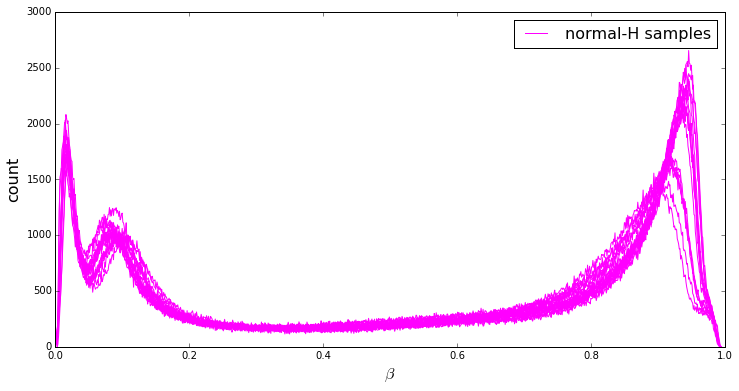

In [11]:
sample_hist=pd.read_csv('sample_beta_hist.csv',header=None,sep='\t',
                     names=['sample','bin','count'])

fig,ax=plt.subplots()
fig.set_size_inches(12,6)
color='magenta'
samples=np.unique(sample_hist['sample'])
for sample in samples:
    idx=(sample_hist['sample']==sample).values
    
    ax.plot(sample_hist.loc[idx,'bin'],
            sample_hist.loc[idx,'count'],
            lw=1,c=color)
ax.plot([],[],label='normal-H samples',c=color)
ax.set_ylabel('count',fontsize=16)
ax.set_xlabel(r'$\beta$',fontsize=16)
dump=ax.legend(loc='best',fontsize=16)

---
## Histogram of median of beta per probe


In [13]:
run_sqlilte3('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

SELECT ROUND(medb*1000)*0.001, COUNT(*)
FROM (SELECT MEDIAN(beta) AS medb
    FROM normal_h_meth
    GROUP BY probe)
GROUP BY ROUND(medb*1000)*0.001;


''',db='../db/meth_db',output='probe_median_beta_hist.csv')


It took 5 s


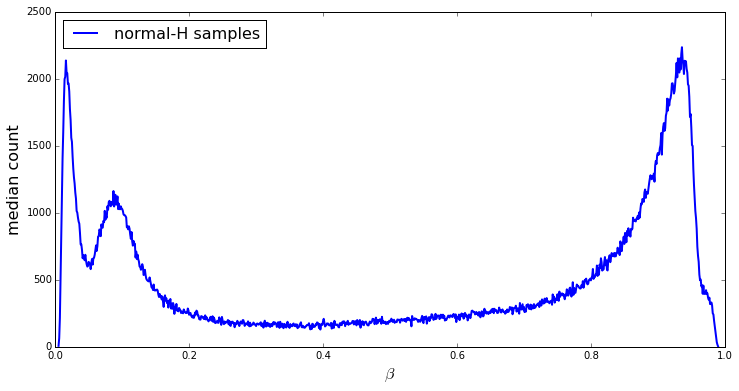

In [18]:
test_hist=pd.read_csv('probe_median_beta_hist.csv',header=None,sep='\t',
                     names=['bin','count'])

fig,ax=plt.subplots()
fig.set_size_inches(12,6)

ax.plot(test_hist['bin'],
       test_hist['count'],
       label='normal-H samples',lw=2)

ax.set_xlabel(r'$\beta$',fontsize=16)
ax.set_ylabel('median count',fontsize=16)
dump=ax.legend(loc='best',fontsize=16)

---

## Standard deviation of probes among samples

In [19]:
run_sqlilte3('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

SELECT ROUND(medb*1000)*0.001, COUNT(*)
FROM (SELECT STDEV(beta) AS medb
    FROM normal_h_meth
    GROUP BY probe)
GROUP BY ROUND(medb*1000)*0.001;

''',db='../db/meth_db',output='probe_std_beta_hist.csv')


It took 4 s


#### Plot the histogram of stds

- Most of them is under 0.1 witht he two peaks, at 0.8, and 0.2 this looks promising

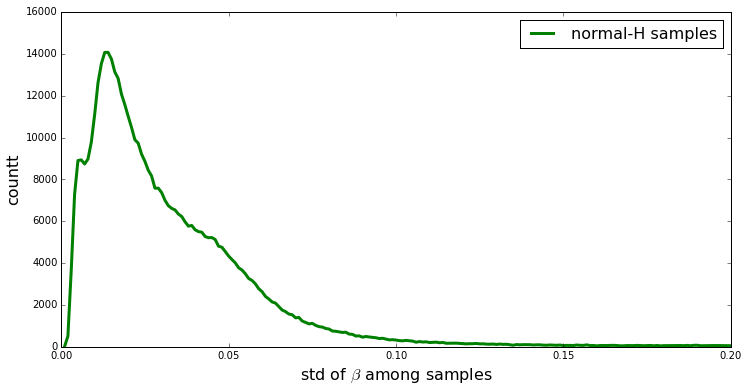

In [23]:
test_hist=pd.read_csv('probe_std_beta_hist.csv',header=None,sep='\t',
                     names=['bin','count'])

fig,ax=plt.subplots()
fig.set_size_inches(12,6)

ax.plot(test_hist['bin'],
       test_hist['count'],
       label='normal-H samples',c='g',lw=3)

ax.set_xlabel(r'std of $\beta$ among samples',fontsize=16)
ax.set_ylabel('countt',fontsize=16)
ax.set_xlim(0,0.2)
dump=ax.legend(loc='best',fontsize=16)